## Importar Bibliotecas

In [44]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

## Carregar e combinar os dados

In [45]:
# Carregar dados de treino e teste
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Carregar sobreviventes do teste e combinar com test_df
survived_df = pd.read_csv('gender_submission.csv')
test_df = test_df.merge(survived_df, on='PassengerId', how='left')  # Adicionar coluna 'Survived' ao test_df

## Tratar valores faltantes

In [ ]:
# Preencher 'Age' com a mediana do treino
age_median = train_df['Age'].median()
train_df['Age'] = train_df['Age'].fillna(age_median)  # Sem inplace=True
test_df['Age'] = test_df['Age'].fillna(age_median)     # Usar a mesma mediana

# Preencher 'Fare' no teste com a mediana do treino
fare_median = train_df['Fare'].median()
test_df['Fare'] = test_df['Fare'].fillna(fare_median)  # Sem inplace=True

# Preencher 'Embarked' com a moda do treino
embarked_mode = train_df['Embarked'].mode()[0]
train_df['Embarked'] = train_df['Embarked'].fillna(embarked_mode)
test_df['Embarked'] = test_df['Embarked'].fillna(embarked_mode)

## Codificar variaveis categorias

In [47]:
# Converter 'Sex' para numérico
for df in [train_df, test_df]:
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# One-hot encoding para 'Embarked'
train_df = pd.get_dummies(train_df, columns=['Embarked'], prefix='Embarked')
test_df = pd.get_dummies(test_df, columns=['Embarked'], prefix='Embarked')

# Garantir que o teste tenha as mesmas colunas que o treino
missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Adicionar colunas faltantes com 0

## Engenharia de features

In [48]:
# Criar 'FamilySize' e 'IsAlone'
for df in [train_df, test_df]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

## Remover colunas nao usadas

In [49]:
# Criar 'FamilySize' e 'IsAlone'
for df in [train_df, test_df]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

## Treinar a arvore de decisao

In [ ]:
# Criar modelo (evitar overfitting)
modelo = DecisionTreeClassifier(
    max_depth=3,           # Controlar profundidade
    min_samples_split=20,  # Mínimo de amostras para dividir um nó
    random_state=42
)

# --- Pré-processamento ---

# 1. Remover colunas não usadas e separar features/target
drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']

# Para o treino:
X_train = train_df.drop(drop_columns + ['Survived'], axis=1)  # Features
y_train = train_df['Survived']                                # Target

# Para o teste (se houver 'Survived' após o merge):
if 'Survived' in test_df.columns:
    X_test = test_df.drop(drop_columns + ['Survived'], axis=1)
    y_test = test_df['Survived']
else:
    X_test = test_df.drop(drop_columns, axis=1)

# 2. Garantir que X_test tenha as mesmas colunas que X_train
# (Importante após one-hot encoding)
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

# 3. Ordenar as colunas de X_test na mesma ordem de X_train
X_test = X_test[X_train.columns]

# Treinar modelo
modelo = DecisionTreeClassifier(
    max_depth=3,           
    min_samples_split=20,  
    random_state=42
)

modelo.fit(X_train, y_train)  # Funcionará agora!

# Treinar
modelo.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_split=20, random_state=42)

## Avaliar o modelo

In [51]:
# Previsões no treino e teste
y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)

# Métricas
print("Acurácia no Treino:", accuracy_score(y_train, y_pred_train))
print("Acurácia no Teste:", accuracy_score(y_test, y_pred_test))
print("\nRelatório de Classificação (Teste):\n", classification_report(y_test, y_pred_test))

Acurácia no Treino: 0.8271604938271605
Acurácia no Teste: 0.9665071770334929

Relatório de Classificação (Teste):
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       266
           1       0.96      0.95      0.95       152

    accuracy                           0.97       418
   macro avg       0.97      0.96      0.96       418
weighted avg       0.97      0.97      0.97       418



## Visualizar a arove

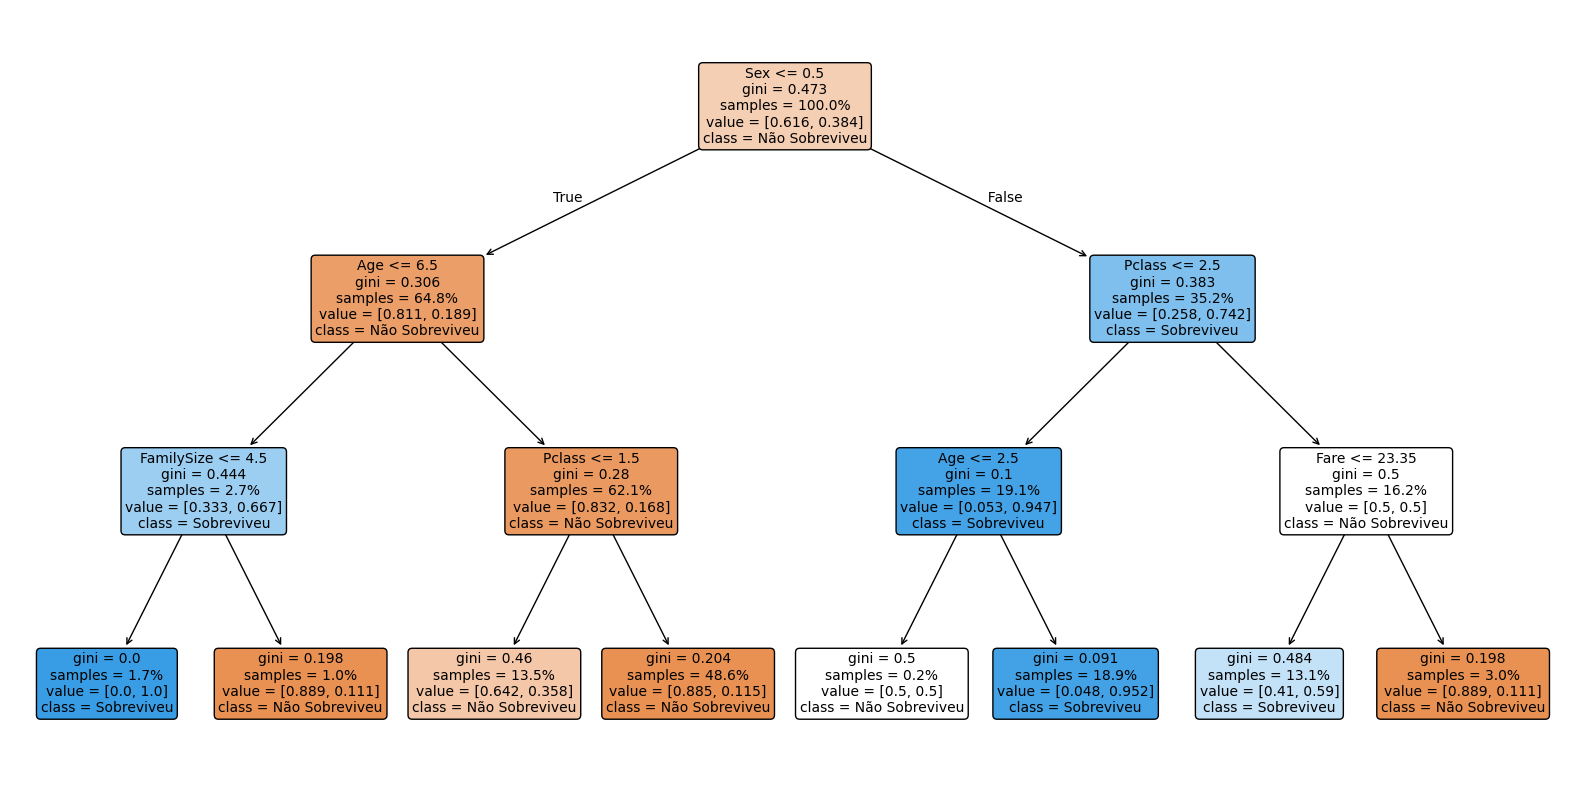

In [52]:
plt.figure(figsize=(20, 10))
plot_tree(
    modelo,
    feature_names=X_train.columns,
    class_names=['Não Sobreviveu', 'Sobreviveu'],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10
)
plt.show()

## Importancia das features

In [53]:
importancias = modelo.feature_importances_
features = pd.DataFrame({'Feature': X_train.columns, 'Importância': importancias})
features = features.sort_values(by='Importância', ascending=False)
print(features)

       Feature  Importância
1          Sex     0.628880
0       Pclass     0.213525
2          Age     0.061867
5         Fare     0.050802
9   FamilySize     0.044927
4        Parch     0.000000
3        SibSp     0.000000
6   Embarked_C     0.000000
7   Embarked_Q     0.000000
8   Embarked_S     0.000000
10     IsAlone     0.000000
